In [10]:
import psycopg2
import networkx as nx
from sshtunnel import SSHTunnelForwarder
import matplotlib.pyplot as plt

In [11]:
server = SSHTunnelForwarder(
    ('10.0.1.139', 22),
    ssh_username='bcadmin',
    ssh_pkey='/Users/mkf26/.ssh/id_ed25519',
    ssh_private_key_password='Poltergeist96!',
    remote_bind_address=('localhost', 5432)
)

server.start()

print(server.local_bind_port)  # show assigned local port
# work with `SECRET SERVICE` through `server.local_bind_port`.

conn = psycopg2.connect(
    database='digital_appraisal_new',
    user='bcadmin',
    host=server.local_bind_host,
    port=server.local_bind_port,
    password='090696')
cur = conn.cursor()

2023-11-27 16:23:57,810| ERROR   | Password is required for key /Users/mkf26/.ssh/id_ed25519


64373


In [12]:
#getting duplicate relationships from database
def getRelationships():
    cur.execute("""
    with DUPES as (
    SELECT
        f1.id AS file_id,
        f1.directory_id,
        f1.file_path,
        f1.file_name,
        f1.md5_hash,
        f1.digital_media_id,
        f1.format_id,
        f1.file_type,
        f1.size,
        f2.id AS duplicate_file_id,
        f2.file_name as duplicate_name,
        f2.file_path as duplicate_file_path,
        f2.digital_media_id as duplicate_media_id
    FROM
        files f1
    JOIN
        files f2
    ON
        f1.md5_hash = f2.md5_hash
    WHERE
        f1.digital_media_id != f2.digital_media_id
        AND f1.id != f2.id
        and f1.appraisal_decision is NULL
        and f2.appraisal_decision is NULL
    )
    
    select digital_media_id, duplicate_media_id,
    count(distinct file_id) as unique_duplicate_file_count
    from DUPES
    join media m1 on digital_media_id = m1.id
    join media m2 on duplicate_media_id = m2.id
    where m1.group_id like '2.%'
    and m2.group_id like '2.%'
    group by digital_media_id, duplicate_media_id
    order by unique_duplicate_file_count desc;""")
    relationships = cur.fetchall()
    #setting a cutoff on number of duplicates for analysis
    min_duplicates = 100
    relationships = list(set([(min(relation[0], relation[1]), max(relation[0], relation[1]), relation[2])  for relation in relationships if relation[2] > min_duplicates]))
    return relationships

# getting nodes from relationships (list of tuples created by above function)
def getNodes(relationships):
    #gets full list of media IDs and file counts from the DB
    cur.execute("""select id, file_count from 
    (select m.id, count(*) as file_count
    from media as m
    left join files as f
    on m.id = f.digital_media_id
    group by m.id
    order by m.id)
    where file_count != 1;""")
    media_ids_counts = cur.fetchall()
    #condenses digital_media_ids from a list of tuples (relationsips) into unique list to compare against
    relevant_media_ids = list(set([media_id for tup in relationships for media_id in tup[:2]]))
    #create list of nodes by comparing against the list of relevant media ids
    nodes = {item[0]: item[1] for item in media_ids_counts if item[0] in relevant_media_ids}
    return nodes

def getEdges(relationships):
    edges = [(relation[0], relation[1]) for relation in relationships]
    return edges

relationships = getRelationships()
nodes = getNodes(relationships)
edges = getEdges(relationships)

print(nodes)
print(edges)

{'D-0210': 144567, 'D-0216': 970655, 'D-0220': 52249, 'D-0221': 111492, 'D-0223': 635958, 'D-0224': 68879, 'D-0232A': 44054, 'D-0251B': 40884, 'D-0251C': 786522, 'D-0251D': 652674, 'D-0251E': 35390, 'D-0258B': 65938, 'D-0258D': 61910}
[('D-0210', 'D-0251D'), ('D-0224', 'D-0251D'), ('D-0216', 'D-0221'), ('D-0216', 'D-0224'), ('D-0223', 'D-0251C'), ('D-0221', 'D-0251C'), ('D-0216', 'D-0223'), ('D-0232A', 'D-0258D'), ('D-0210', 'D-0220'), ('D-0216', 'D-0220'), ('D-0251C', 'D-0258D'), ('D-0221', 'D-0232A'), ('D-0220', 'D-0223'), ('D-0210', 'D-0220'), ('D-0221', 'D-0232A'), ('D-0221', 'D-0258B'), ('D-0221', 'D-0223'), ('D-0224', 'D-0258D'), ('D-0221', 'D-0251D'), ('D-0220', 'D-0258D'), ('D-0210', 'D-0251C'), ('D-0221', 'D-0223'), ('D-0216', 'D-0221'), ('D-0251C', 'D-0251D'), ('D-0258B', 'D-0258D'), ('D-0223', 'D-0232A'), ('D-0251C', 'D-0251E'), ('D-0220', 'D-0232A'), ('D-0216', 'D-0251D'), ('D-0210', 'D-0216'), ('D-0210', 'D-0251C'), ('D-0223', 'D-0258B'), ('D-0224', 'D-0232A'), ('D-0251C',

{('D-0210',
  'D-0251D'): Text(0.2835835963487625, 0.2547578550875187, '7389 duplicate files'),
 ('D-0224',
  'D-0251D'): Text(0.2590322270989418, 0.11809324100613594, '103 duplicate files'),
 ('D-0216',
  'D-0221'): Text(0.5773695707321167, 0.49845799058675766, '38186 duplicate files'),
 ('D-0216',
  'D-0224'): Text(0.40301816910505295, 0.4581198990345001, '1096 duplicate files'),
 ('D-0223',
  'D-0251C'): Text(0.061682265251874924, 0.3171567842364311, '67271 duplicate files'),
 ('D-0221',
  'D-0251C'): Text(0.3357873037457466, 0.18753688037395477, '58080 duplicate files'),
 ('D-0216',
  'D-0223'): Text(0.303264532238245, 0.628077894449234, '67268 duplicate files'),
 ('D-0232A',
  'D-0258D'): Text(0.3841344118118286, 0.5455253422260284, '9972 duplicate files'),
 ('D-0210',
  'D-0220'): Text(0.6207236051559448, 0.3969951272010803, '9782 duplicate files'),
 ('D-0216',
  'D-0220'): Text(0.7804067432880402, 0.553984984755516, '12715 duplicate files'),
 ('D-0251C',
  'D-0258D'): Text(0.221

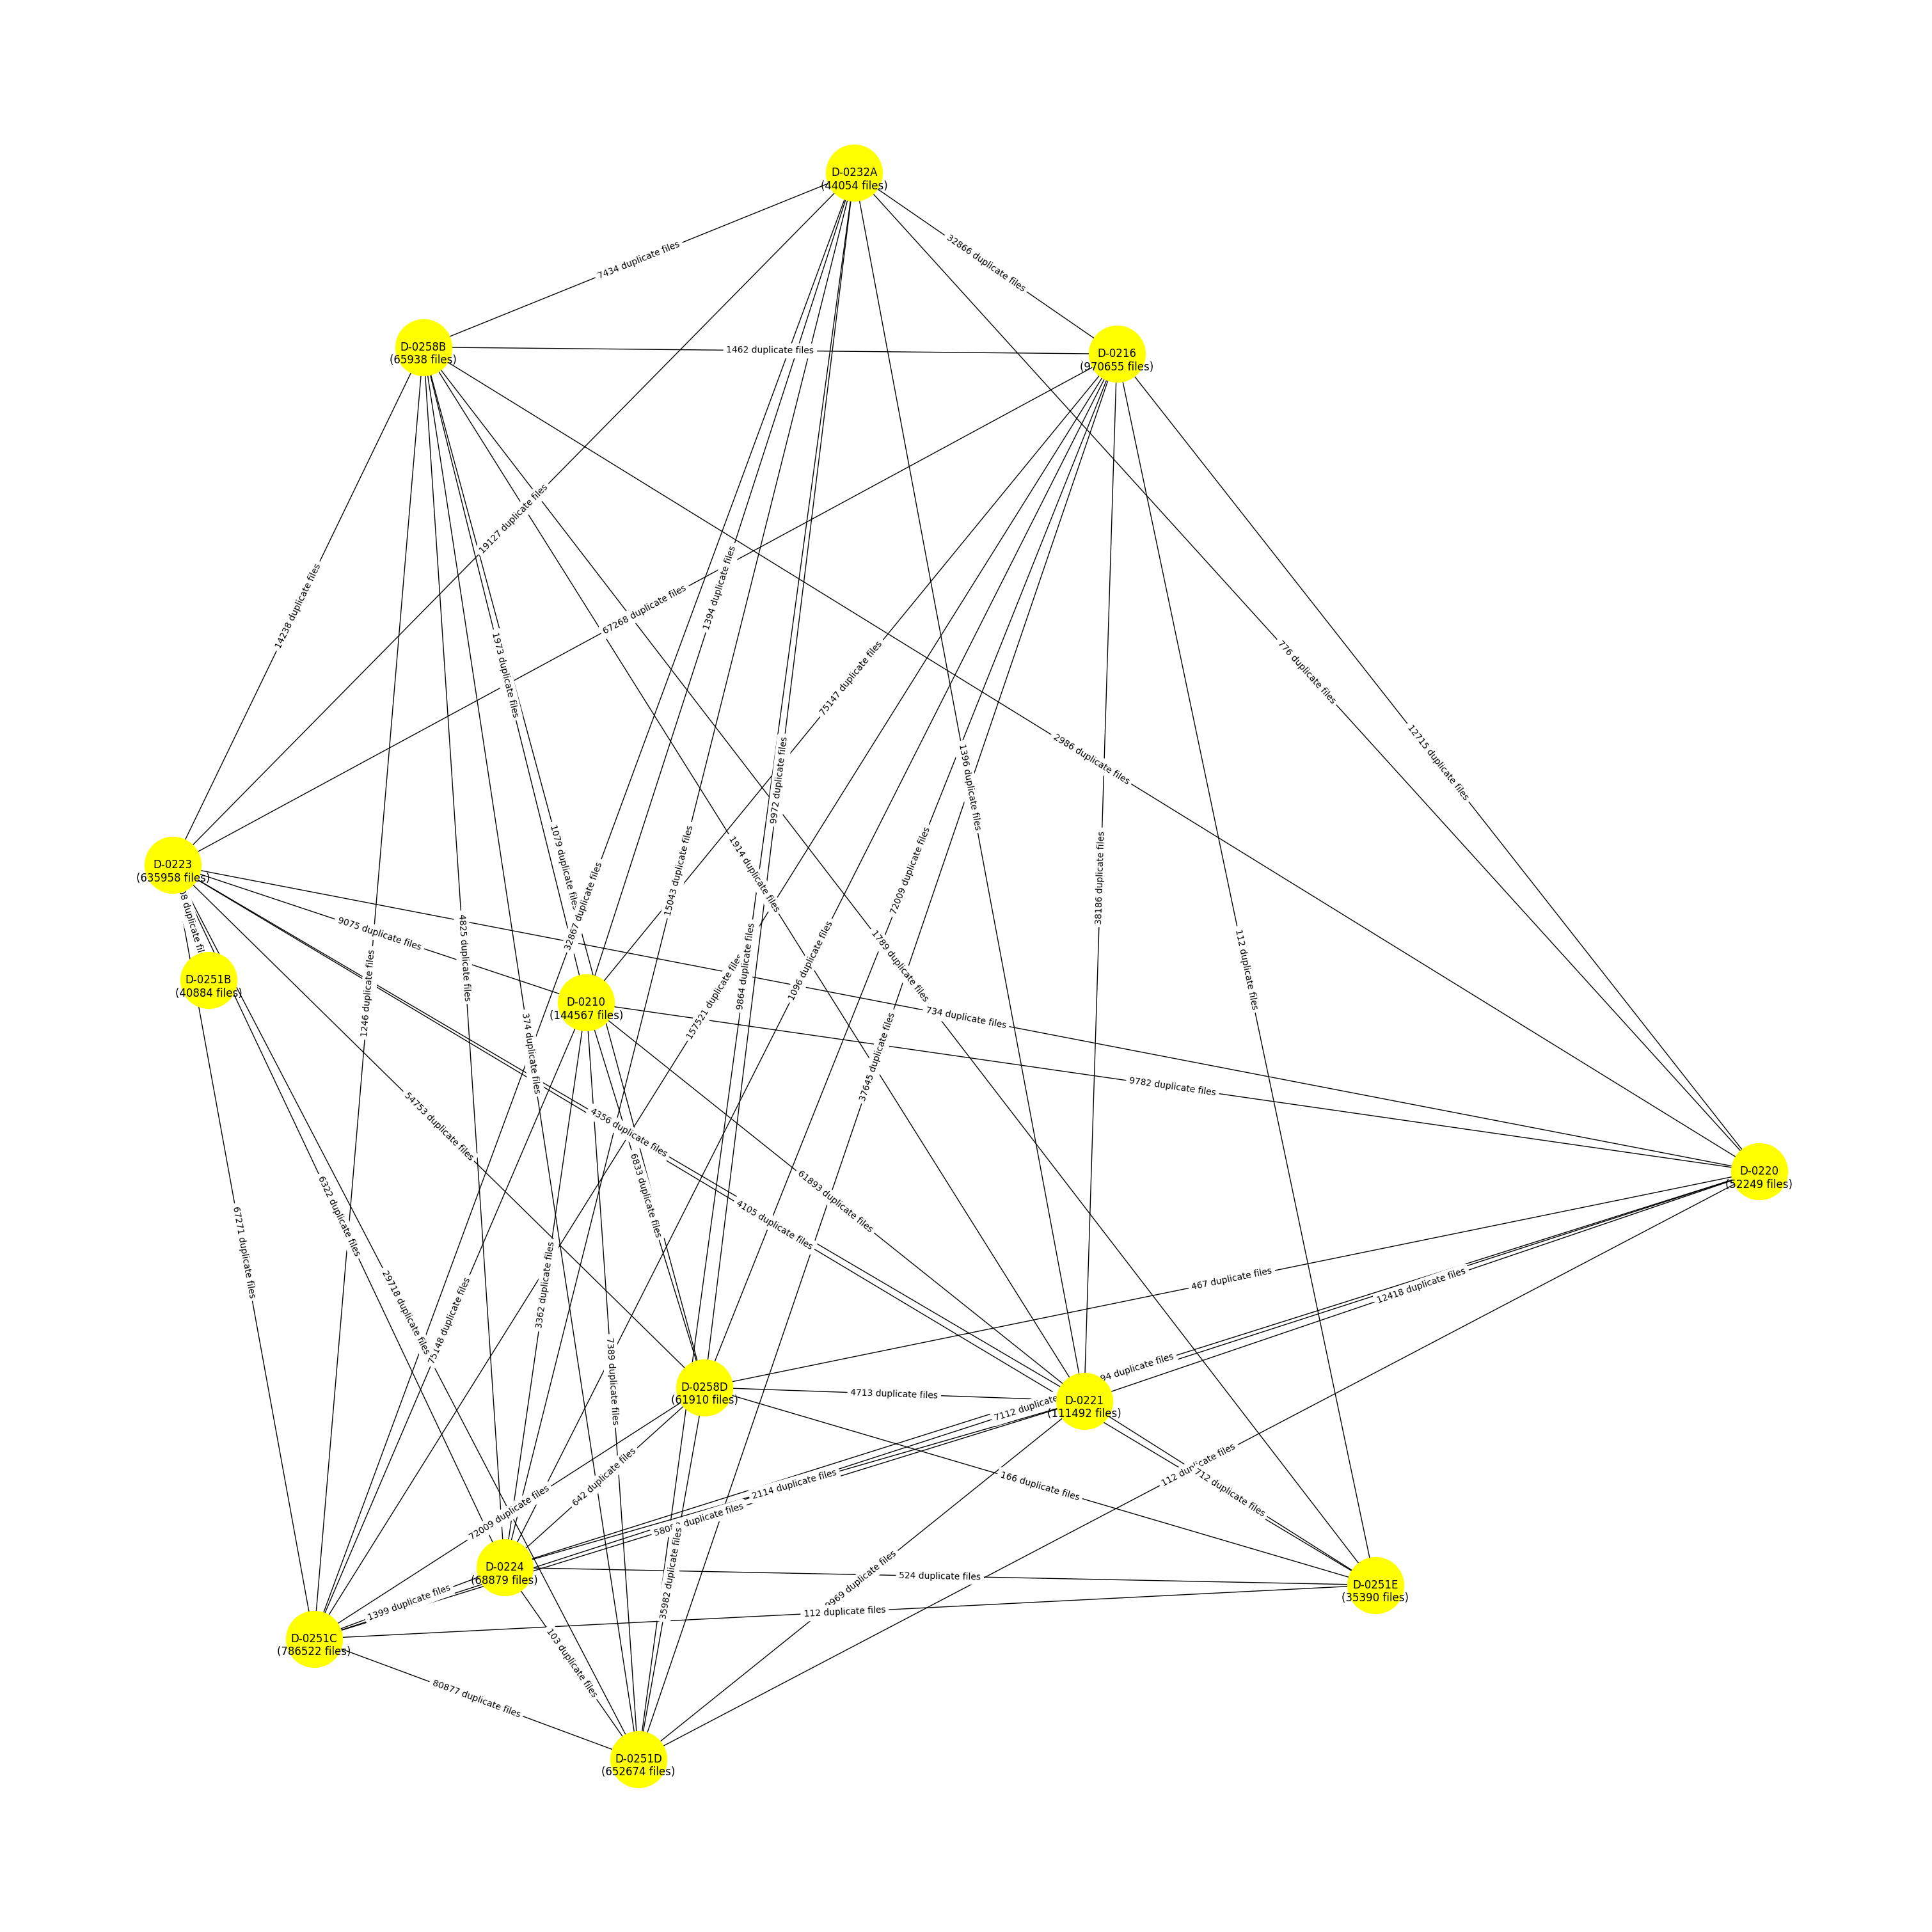

In [16]:
G = nx.Graph()

G.add_nodes_from(nodes.keys())
G.add_edges_from(edges)

plt.figure(figsize=(30, 30))

options = {
    'node_color': 'yellow',
    'node_size': 4000,
    'width': 1,

}
pos = nx.random_layout(G)
nx.draw(G, pos, with_labels = True, **options)

nx.draw_networkx_labels(
    G,
    pos,
    labels={media_id: f"\n\n({nodes[media_id]} files)" for media_id in nodes.keys()}
)

nx.draw_networkx_edge_labels(
    G,
    pos,
    edge_labels={(relation[0], relation[1]): f"{relation[2]} duplicate files" for relation in relationships}
)


In [1]:
cur.close()
conn.close()
server.stop()

NameError: name 'cur' is not defined